Script for modeling calcium diffusion in a rectangular tube with zero flux in the x-, y-, and z-directions.

Last updated: 11/19/21 12:57PM

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS
L_x = 4     # X LENGTH (um)
L_y = 0.5   # Y LENGTH (um)
L_z = 0.5   # Z LENGTH (um)

x_o = 2.35  # VDCC X LOC (um)
y_o = 0.25  # VDCC Y LOC (um)
z_o = 0     # VDCC Z LOC (um)
t_o = 0     # C rel time (usec)

x_s = 2       # SNARE BOX CENTER X LOC (um)
y_s = 0.25    # SNARE BOX CENTER Y LOC (um)
z_s = 0       # SNARE BOX CENTER Z LOC (um)

'''
delta_x = 0.040   # SNARE BOX X LEN (um)
delta_y = 0.035   # SNARE BOX Y LEN (um)
delta_z = 0.05    # SNARE BOX X LEN (um)
'''

delta_x = 0.1   # SNARE BOX X LEN (um)
delta_y = 0.1   # SNARE BOX Y LEN (um)
delta_z = 0.1    # SNARE BOX X LEN (um)

N_ca = 5275 # no. of ca
conc_ca_init = N_ca / (6.022e23 * 1e-15)
D = 2.20e-4     # Diffusion coeff (um^2/usec)


# Test
K = 20       # X eigenmodes
L = 20       # Y eigenmodes
M = 20       # Z eigenmodes
t = 10       # time of interest (microsec, usec) "MCell models were also run 1,000 times for 10 $ms$ with a timestep of 1 $\mu s$"

In [4]:
def int_g_xk(x_o, t_o, x, t, delta_x, k):
    """Integrates x-direction Green's component

    Integrates the individual x-direction Green's components for a given eigenmode (k)
    for a box with y-dimension delta_x centered at x at time t given an initial impulse
    at x_o at t = t_o
    
    Args:
      x_o: 
        location of calcium impulse input, y-direction
      t_o:
        time of calcium impulse input
      x:
        location of interest point, y-direction
      t:
        time of interest point
      k:
        z-direction eigenmode

    Returns:
      A singular value giving the value of the integrated individual x-direction Green's components
    """

    if k == 0:
        int_g_xk = 2 * delta_x / L_x
    
    else:
        int_g_xk = (4 / (k * math.pi)) * math.cos((k * math.pi * x_o) / L_x) \
            * math.cos((k * math.pi * x) / L_x) \
            * math.sin((k * math.pi * delta_x)/(L_x * 2))\
            * math.exp(-D * ((k * math.pi) / L_x)**2 * (t - t_o))

    return int_g_xk

In [5]:
def int_g_yl(y_o, t_o, y, t, delta_y, l):
    """Integrates y-direction Green's component

    Integrates the individual y-direction Green's components for a given eigenmode (l)
    for a box with y-dimension delta_y centered at y at time t given an initial impulse
    at y_o at t = t_o
    
    Args:
      y_o: 
        location of calcium impulse input, y-direction
      t_o:
        time of calcium impulse input
      y:
        location of interest point, y-direction
      t:
        time of interest point
      l:
        z-direction eigenmode

    Returns:
      A singular value giving the value of the integrated individual y-direction Green's components
    """

    if l == 0:
        int_g_yl = 2 * delta_y / L_y

    else: 
        int_g_yl = (4 / (l * math.pi)) * math.cos((l * math.pi * y_o) / L_y) \
            * math.cos((l * math.pi * y) / L_y) \
            * math.sin((l * math.pi * delta_y) / (L_y * 2))\
            * math.exp(-D * ((l * math.pi) / L_y)**2 * (t - t_o))
        
    return int_g_yl

In [14]:
def int_g_zm(z_o, t_o, z, t, delta_z, m):
    """Integrates z-direction Green's component

    Integrates the individual z-direction Green's components for a given eigenmode (m)
    for a box with z-dimension delta_z centered at z at time t given an initial impulse
    at z_o at t = t_o
    
    Args:
      z_o: 
        location of calcium impulse input, z-direction
      t_o:
        time of calcium impulse input
      z:
        location of interest point, z-direction
      t:
        time of interest point
      m:
        z-direction eigenmode

    Returns:
      A singular value giving the value of the integrated individual z-direction Green's components
    """
    
    if m == 0:
        int_g_zm = delta_z / L_z
    
    else:
        int_g_yl = (2 / (m * math.pi)) * math.cos((m * math.pi * z_o) / L_z) \
            * math.cos((m * math.pi * z) / L_z) \
            * math.sin((m * math.pi * delta_z) / (L_z * 2))\
            * math.exp(-D * (m * math.pi / L_z)**2 * (t - t_o))
        
    return int_g_zm

In [7]:
def int_G(impulse_xyzt, interest_xyzt, box_dim_xyz, eigenmodes_klm):
    """Sums Green's components for all directions and eigenmodes
    
    Sums the individual x-, y-, and z-direction Green's components across the desired number of
    eigenmodes to give the normalized number of calcium molecules in a box with dimensions 
    (delta_x, delta_y, delta_z) centered at point (x, y, z) at time t given an initial impulse
    of N_ca at (x_o, y_o, z_o) at t = t_o
    
    Args:
      impulse_xyzt: 
        location and time of calcium impulse input; (x_o, y_o, z_o, t_o)
      interest_xyzt: 
        location and time of interest point; (x, y, z, t)
      box_dim_xyz: 
        dimensions of box of interest centered at interest_xyzt; (delta_x, delta_y, delta_z) 
      eigenmodes_klm: 
        total number of eigenmodes in x, y, and z directions accordingly; (K, L, M)

    Returns:
      A singular value giving the normalized number calcium molecules in a box with dimensions
      given by box_dim_xyz centered at/at time given by interest_xyzt
    """
    # unpack args
    (x_o, y_o, z_o, t_o) = impulse_xyzt
    (x, y, z, t) = interest_xyzt
    (delta_x, delta_y, delta_z)  = box_dim_xyz
    (K, L, M) = eigenmodes_klm

    int_G = 0 # initialize

    # sum across all eigenmodes of interest
    for k in range(0, K):
        for l in range(0, L):
            for m in range(0, M):
                int_G += int_g_xk(x_o, t_o, x, t, delta_x, k) * int_g_yl(y_o, t_o, y, t, delta_y, l) * int_g_zm(z_o, t_o, z, t, delta_z, m)

    return int_G

In [8]:
def u(N_ca, impulse_xyzt, interest_xyzt, box_dim_xyz, eigenmodes_klm):
    """Returns number of calcium 
    
    Scales the normalized number of calcium molecules in a box with dimensions (delta_x, delta_y, delta_z) centered at
    point (x, y, z) at time t by the initial impulse of N_ca at (x_o, y_o, z_o) at t = t_o
    
    Args:
      N_ca:
        the number of initial calcium molecules in the impulse injection
      impulse_xyzt: 
        location and time of calcium impulse input; (x_o, y_o, z_o, t_o)
      interest_xyzt: 
        location and time of interest point; (x, y, z, t)
      box_dim_xyz: 
        dimensions of box of interest centered at interest_xyzt; (delta_x, delta_y, delta_z) 
      eigenmodes_klm: 
        total number of eigenmodes in x, y, and z directions accordingly; (K, L, M)

    Returns:
      A singular value giving the number of calcium molecules in a box with dimensions
      given by box_dim_xyz centered at/at time given by interest_xyzt
    """
     
    u = N_ca * int_G(impulse_xyzt, interest_xyzt, box_dim_xyz, eigenmodes_klm) 
    
    return u

In [9]:
u(N_ca, (x_o, y_o, z_o, t_o), (x_s, y_s, z_s, t), (delta_x, delta_y, delta_z), (K, L, M))
#def int_G(x_s, y_s, z_s, t, x_o, y_o, z_o, t_o, delta_x, delta_y, delta_z, K, L, M):

-64.51555208317394

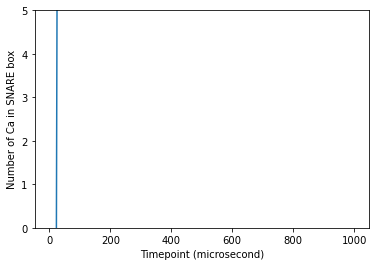

In [10]:
timepoints = np.linspace(1, 1000, 200)
ca_s = []

for t in timepoints:
    ca_s.append(u(N_ca, (x_o, y_o, z_o, t_o), (x_s, y_s, z_s, t), (delta_x, delta_y, delta_z), (K, L, M)))


plt.plot(timepoints, ca_s)
#plt.yscale('log')
plt.ylim([0,5])
plt.xlabel("Timepoint (microsecond)")
plt.ylabel("Number of Ca in SNARE box")
plt.show()
    

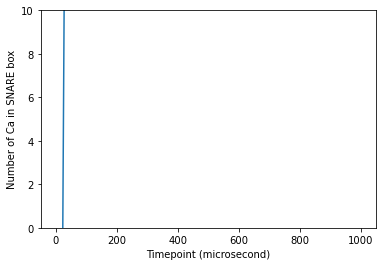

In [13]:
plt.plot(timepoints, ca_s)
#plt.yscale('log')
plt.ylim([0,10])
plt.xlabel("Timepoint (microsecond)")
plt.ylabel("Number of Ca in SNARE box")
plt.show()

In [ ]:
def eigenmode_checker(x_s, y_s, z_s, t, x_o, y_o, z_o, t_o, delta_x, delta_y, delta_z, K, L, M):
    '''
    Determine how many eigenmodes are necessary.

    :param (x_s, y_s, z_s)
    '''

    # 
    int_G = int_g_xk(x_s, t, x_o, t_o, delta_x, k) * int_g_yl(y_s, t, y_o, t_o, delta_y, l) * int_g_zm(z_s, t, z_o, t_o, delta_z, m)

    # input the largest eigenmode and check what t value is needed to decay it
    # 10 * 1/largest eigenvalue to get a ballpark
    for k in range(0, K):
        for l in range(0, L):
            for m in range(0, M):
                int_G += int_g_xk(x_s, t, x_o, t_o, delta_x, k) * int_g_yl(y_s, t, y_o, t_o, delta_y, l) * int_g_zm(z_s, t, z_o, t_o, delta_z, m)

    return int_G